In [1]:
!git clone https://github.com/ksideks/UCSD.git

fatal: docelowa ścieżka „UCSD” już istnieje i nie jest pustym katalogiem.


In [2]:
!pip install keras-layer-normalization

In [3]:
TestVideoFile = {}
TestVideoFile[1] = range(59,152)
TestVideoFile[2] = range(49,175)
TestVideoFile[3] = range(90,200)
TestVideoFile[4] = range(30,168)
TestVideoFile[5] = list(range(4,90)) + list(range(139,200))
TestVideoFile[6] = list(range(0,100)) + list(range(109,200))
TestVideoFile[7] = range(0,175)
TestVideoFile[8] = range(0,94)
TestVideoFile[9] = range(0,48)
TestVideoFile[10] = range(0,140)
TestVideoFile[11] = range(69,165)
TestVideoFile[12] = range(130,200)
TestVideoFile[13] = range(0,156)
TestVideoFile[14] = range(6,200)
TestVideoFile[15] = range(137,200)
TestVideoFile[16] = range(122,200)
TestVideoFile[17] = range(0,47)
TestVideoFile[18] = range(53,120)
TestVideoFile[19] = range(63,138)
TestVideoFile[20] = range(44,175)
TestVideoFile[21] = range(30,200)
TestVideoFile[22] = range(16,107)
TestVideoFile[23] = range(8,165)
TestVideoFile[24] = range(49,171)
TestVideoFile[25] = range(39,135)
TestVideoFile[26] = range(77,144)
TestVideoFile[27] = range(9,122)
TestVideoFile[28] = range(104,200)
TestVideoFile[29] = list(range(0,15)) + list(range(44,113))
TestVideoFile[30] = range(174,200)
TestVideoFile[31] = range(0,180)
TestVideoFile[32] = list(range(0,52)) + list(range(64,115))
TestVideoFile[33] = range(4,165)
TestVideoFile[34] = range(0,121)
TestVideoFile[35] = range(85,200)
TestVideoFile[36] = range(14,108)

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [14]:
class Config:
  DATASET_PATH ="UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
  TEST_PATH ="UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test"
  SINGLE_TEST_VIDEO_FILE = 1
  SINGLE_TEST_PATH = "UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test001"
  BATCH_SIZE = 4
  EPOCHS = 3
  MODEL_PATH = "UCSD_v5/model.hdf5"
  THRESHOLD = 0.95

In [6]:
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve
def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The desired distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the desired LSTM sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(np.copy(clip))
                cnt = 0
    return clips


def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    #####################################
    # cache = shelve.open(Config.CACHE_PATH)
    # return cache["datasetLSTM"]
    #####################################
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(Config.DATASET_PATH)):
        if isdir(join(Config.DATASET_PATH, f)):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(join(Config.DATASET_PATH, f))):
                if str(join(join(Config.DATASET_PATH, f), c))[-3:] == "tif":
                    img = Image.open(join(join(Config.DATASET_PATH, f), c)).resize((256, 256))
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return clips

In [7]:
import keras
import tensorflow as tf 
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
from keras.models import Sequential, load_model
def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if not reload_model:
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    training_set = get_training_set()
    training_set = np.array(training_set)
    training_set = training_set.reshape(-1,10,256,256,1)
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    seq.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6))
    seq.fit(training_set, training_set,
            batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False)
    seq.save(Config.MODEL_PATH)
    return seq

2021-11-05 22:31:17.675589: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-05 22:31:17.675638: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [8]:
def get_single_test():
    sz = 200
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "tif":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

def evaluate(reload_model=False):
    model = get_model(reload_model)
    print("got model")
    test = get_single_test()
    print(test.shape)
    sz = test.shape[0] - 10 + 1
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    print("got data")
    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

    return sr, sequences

2021-11-05 22:31:31.175174: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-05 22:31:31.175216: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-05 22:31:31.175267: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ml): /proc/driver/nvidia/version does not exist
2021-11-05 22:31:31.175555: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


got model
(200, 256, 256, 1)
got data


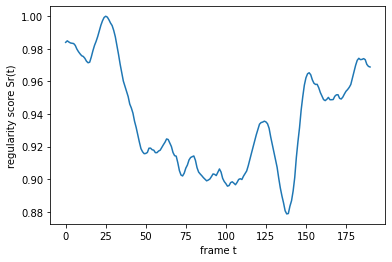

In [10]:
pr, before_reconstuction = evaluate()

AUC:  0.9766293614219883
EER:  0.10752688172043011
EER THRESHOLD:  0.9272583346157088
Optimal threshold value is: 0.9404690493760438


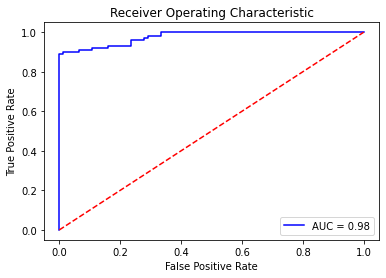

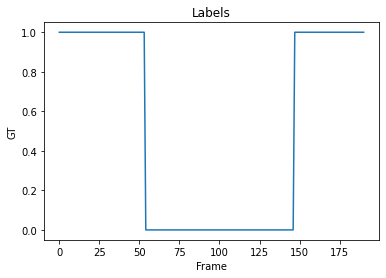

(0.9766293614219883, 0.10752688172043011)

In [11]:
from sklearn import metrics

def plotROC(pr):
  y_pred = pr
  y_test = [1 for element in range(0, 200)]

  for i in TestVideoFile[Config.SINGLE_TEST_VIDEO_FILE]:
    y_test[i] = 0

  #wariant 1 
  # y_test = y_test[9:]
  #wariant 2
  #y_test = y_test[:191]
  #wariant 3
  y_test = y_test[5:196]

  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
  fnr = 1 - tpr
  auc = metrics.roc_auc_score(y_test, y_pred)

  eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
  eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

  optimal = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal]


  #print("FPR: ", fpr)
  #print("TPR: ", tpr)
  #print("THRESHOLDS", thresholds)
  print("AUC: ", auc)
  print("EER: ", eer)
  print("EER THRESHOLD: ", eer_threshold)
  print("Optimal threshold value is:", optimal_threshold)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')  
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  plt.plot(y_test)
  plt.title('Labels')
  plt.ylabel('GT')
  plt.xlabel('Frame')
  plt.show()

  return auc, eer

plotROC(pr)


PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test001
GT:  1
got model
(200, 256, 256, 1)
got data


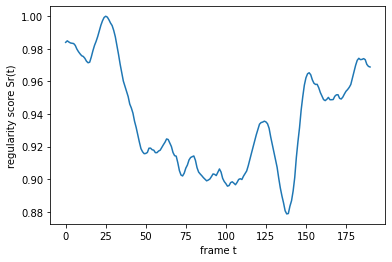

AUC:  0.9766293614219883
EER:  0.10752688172043011
EER THRESHOLD:  0.9272583346157088
Optimal threshold value is: 0.9404690493760438


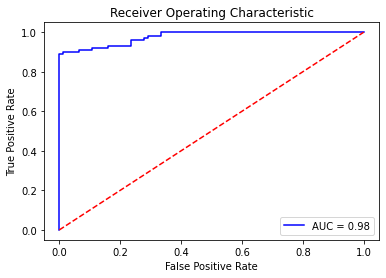

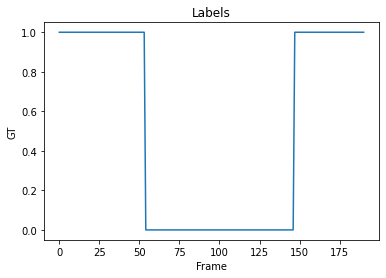

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test002
GT:  2
got model
(200, 256, 256, 1)
got data


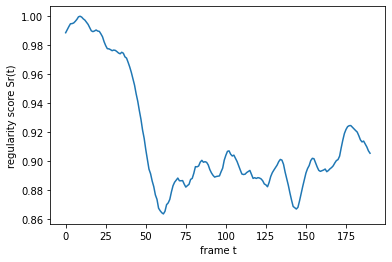

AUC:  0.9838827838827839
EER:  0.05555555555555555
EER THRESHOLD:  0.907870928349854
Optimal threshold value is: 0.9069541967318957


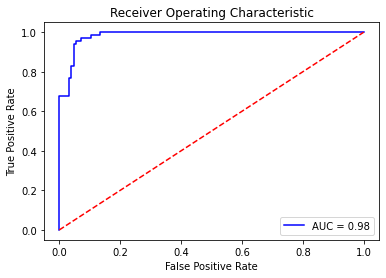

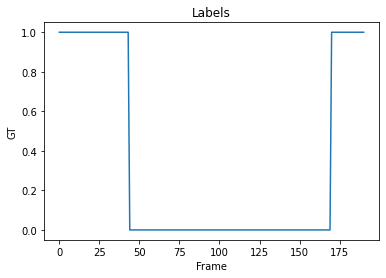

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test003
GT:  3
got model
(200, 256, 256, 1)
got data


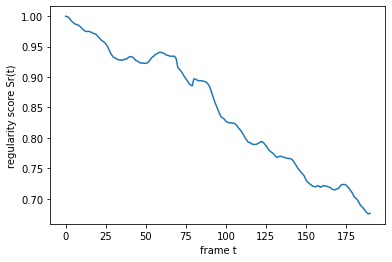

AUC:  0.9983351831298557
EER:  0.03773584905660377
EER THRESHOLD:  0.8912174626695136
Optimal threshold value is: 0.8938089516722383


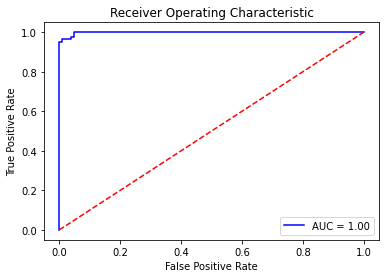

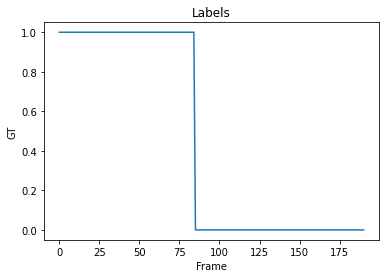

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test004
GT:  4
got model
(200, 256, 256, 1)
got data


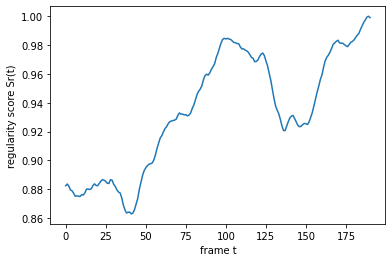

AUC:  0.5501777413180202
EER:  0.18115942028985507
EER THRESHOLD:  0.9715213759670228
Optimal threshold value is: 0.9776395378097141


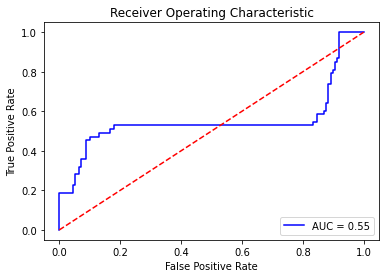

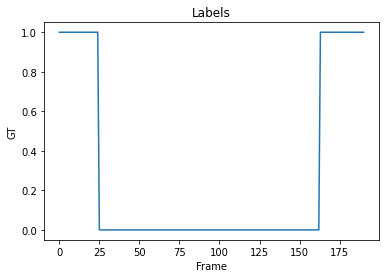

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test005
GT:  5
got model
(200, 256, 256, 1)
got data


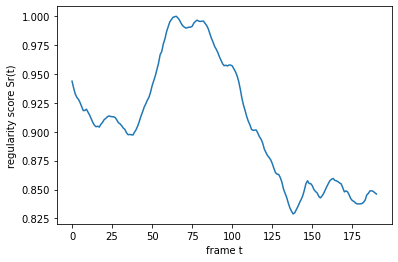

AUC:  0.5908306984765737
EER:  0.4507042253521127
EER THRESHOLD:  0.9092001868015419
Optimal threshold value is: 0.8602957702096088


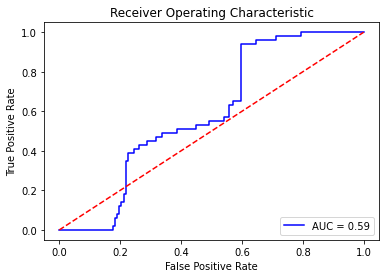

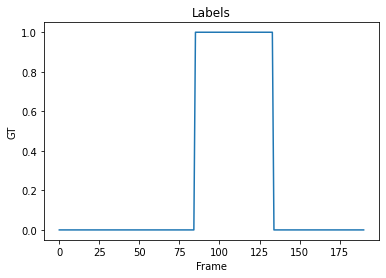

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test006
GT:  6
got model
(200, 256, 256, 1)
got data


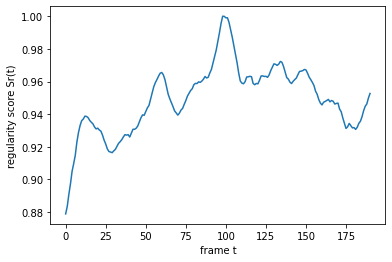

AUC:  0.9993894993894994
EER:  0.005494505494505495
EER THRESHOLD:  0.9846180635702645
Optimal threshold value is: 0.9846180635702645


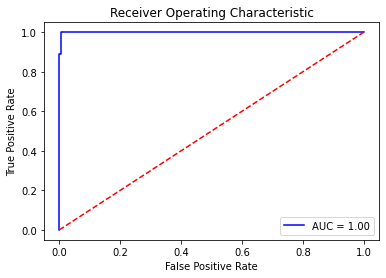

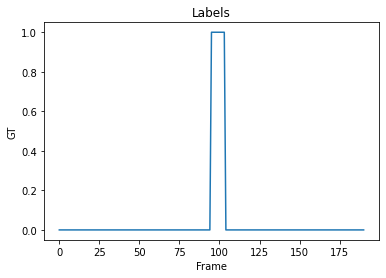

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test007
GT:  7
got model
(200, 256, 256, 1)
got data


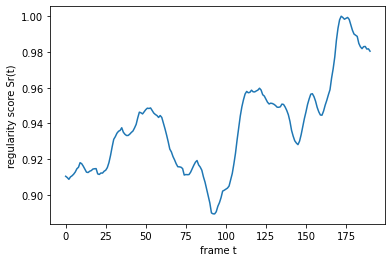

AUC:  0.9977591036414566
EER:  0.0058823529411764705
EER THRESHOLD:  0.9804426969526291
Optimal threshold value is: 0.9804426969526291


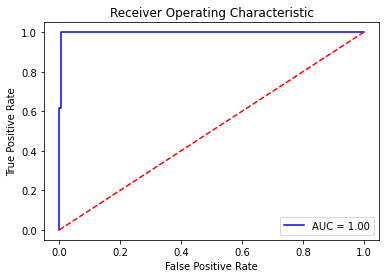

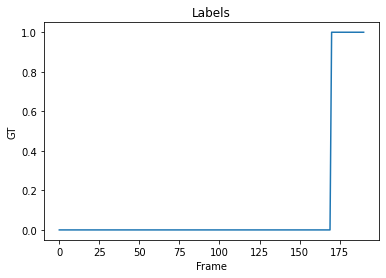

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test008
GT:  8
got model
(200, 256, 256, 1)
got data


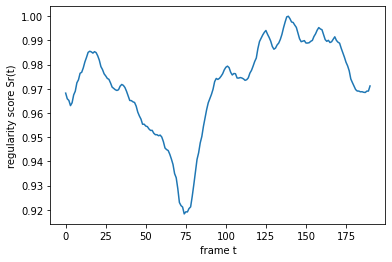

AUC:  0.8940295219211281
EER:  0.20224719101123595
EER THRESHOLD:  0.9740683761925584
Optimal threshold value is: 0.9725602465293464


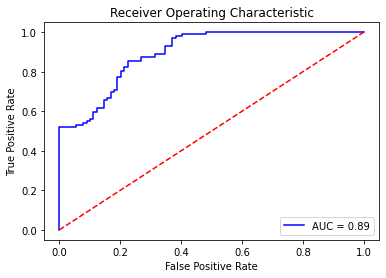

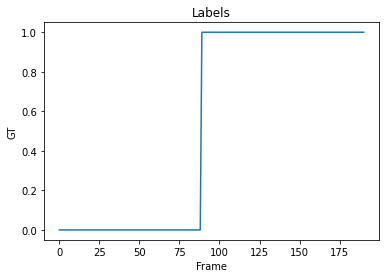

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test009
GT:  9
got model
(200, 256, 256, 1)
got data


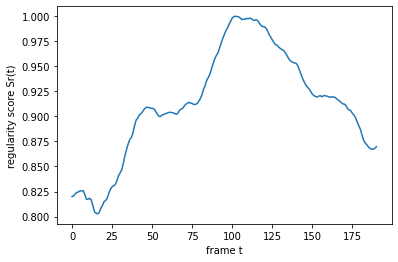

AUC:  0.98585795097423
EER:  0.06976744186046512
EER THRESHOLD:  0.8905884105669957
Optimal threshold value is: 0.8986051889897531


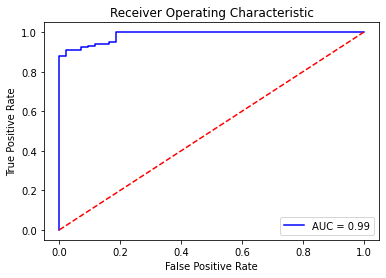

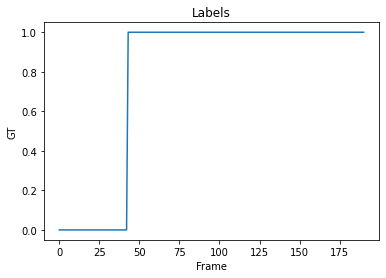

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test010
GT:  10
got model
(200, 256, 256, 1)
got data


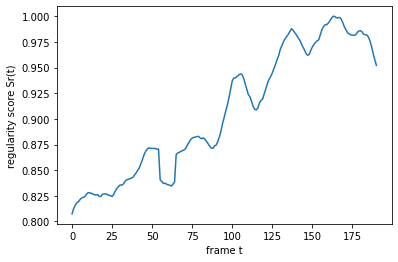

AUC:  0.98994708994709
EER:  0.037037037037037035
EER THRESHOLD:  0.9620451307525097
Optimal threshold value is: 0.9521581727392868


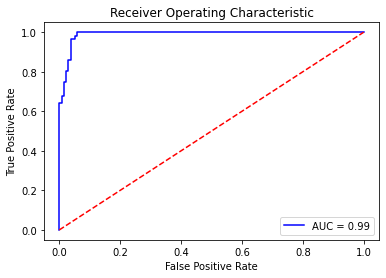

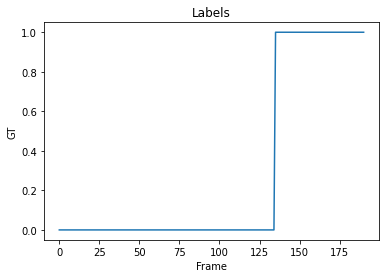

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test011
GT:  11
got model
(200, 256, 256, 1)
got data


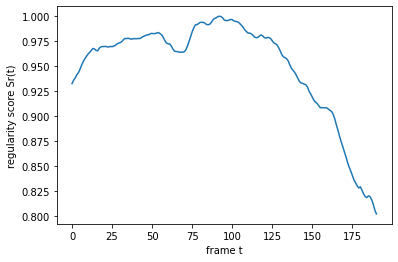

AUC:  0.2913377192982456
EER:  0.59375
EER THRESHOLD:  0.9700007919758564
Optimal threshold value is: 2.0


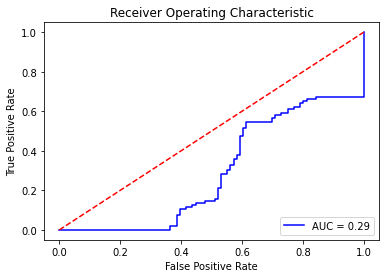

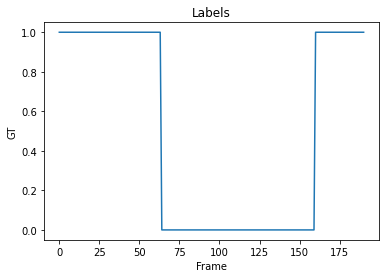

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test012
GT:  12
got model
(200, 256, 256, 1)
got data


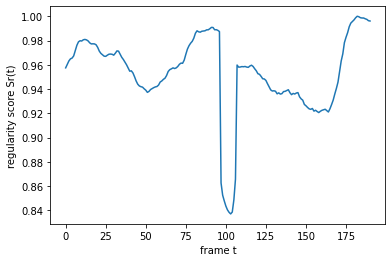

AUC:  0.6613333333333333
EER:  0.30303030303030304
EER THRESHOLD:  0.9544062974340272
Optimal threshold value is: 0.9396174812984216


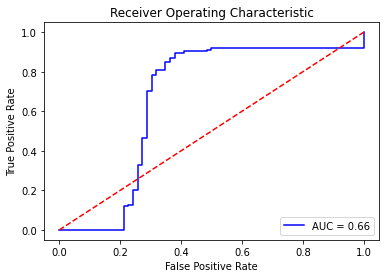

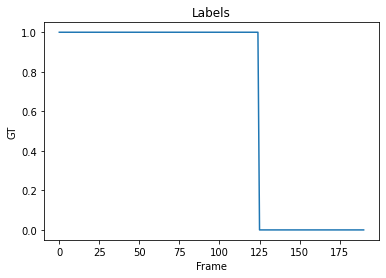

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test013
GT:  13
got model
(200, 256, 256, 1)
got data


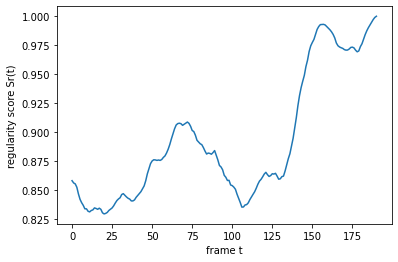

AUC:  0.9947019867549669
EER:  0.019867549668874173
EER THRESHOLD:  0.9695380535433369
Optimal threshold value is: 0.9693024370435877


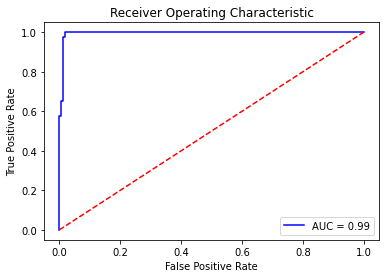

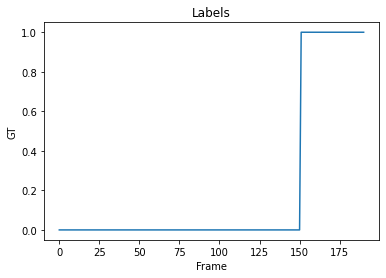

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test014
GT:  14
got model
(200, 256, 256, 1)
got data


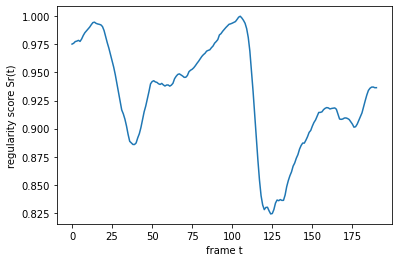

AUC:  0.7684210526315789
EER:  0.23157894736842105
EER THRESHOLD:  0.975214336388434
Optimal threshold value is: 0.975214336388434


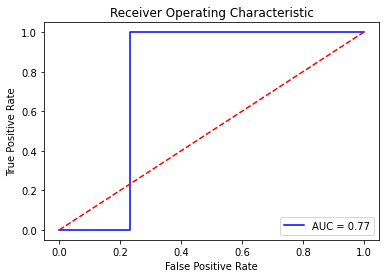

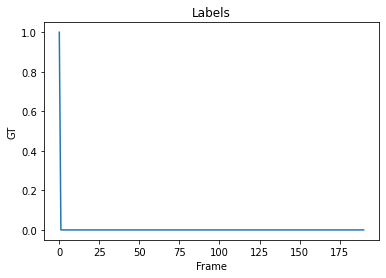

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test015
GT:  15
got model
(200, 256, 256, 1)
got data


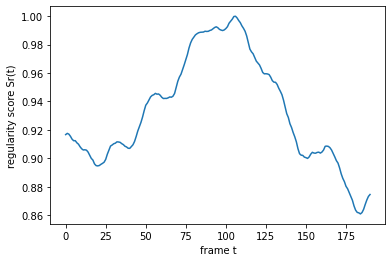

AUC:  0.8678736517719569
EER:  0.22033898305084745
EER THRESHOLD:  0.908599650978678
Optimal threshold value is: 0.908599650978678


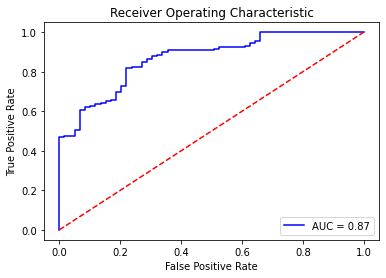

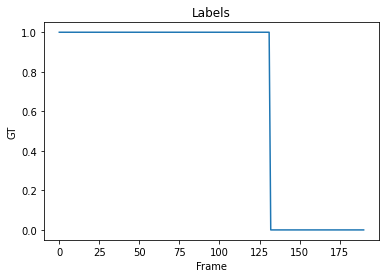

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test016
GT:  16
got model
(200, 256, 256, 1)
got data


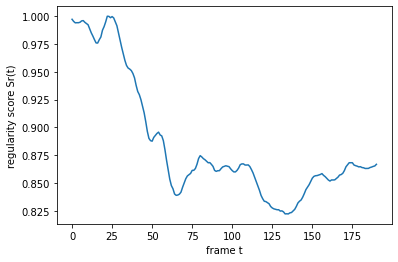

AUC:  0.8705243705243705
EER:  0.2702702702702703
EER THRESHOLD:  0.8631185865836923
Optimal threshold value is: 0.8683904880729252


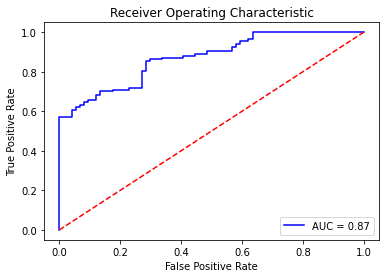

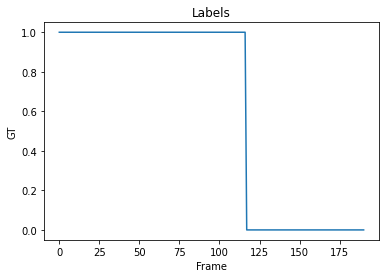

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test018
GT:  18
got model
(200, 256, 256, 1)
got data


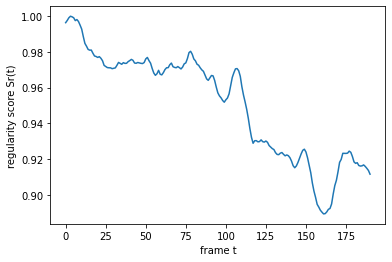

AUC:  0.3390707751564757
EER:  0.43283582089552236
EER THRESHOLD:  0.9706191723138421
Optimal threshold value is: 0.980993141441558


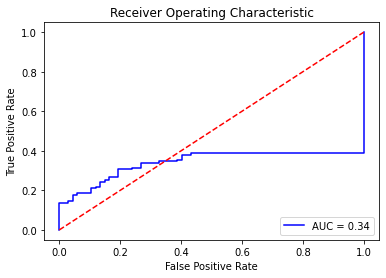

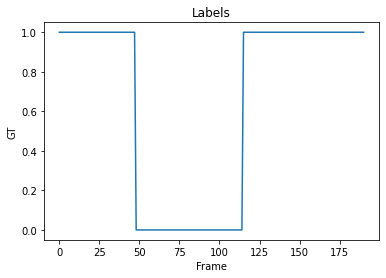

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test019
GT:  19
got model
(200, 256, 256, 1)
got data


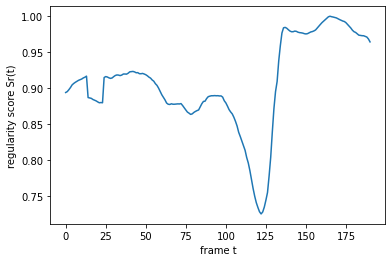

AUC:  0.9768965517241379
EER:  0.05333333333333334
EER THRESHOLD:  0.893841854131309
Optimal threshold value is: 0.9007717312945438


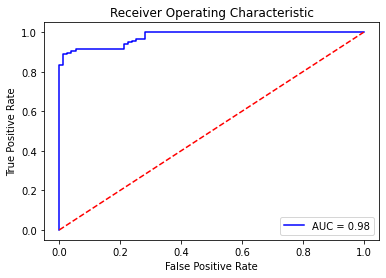

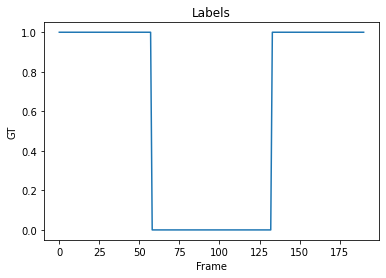

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test020
GT:  20
got model
(200, 256, 256, 1)
got data


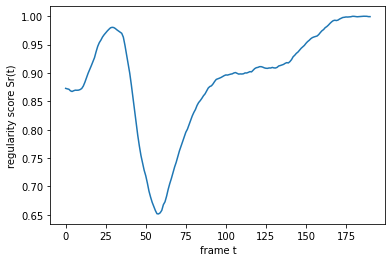

AUC:  0.7914758269720101
EER:  0.2824427480916031
EER THRESHOLD:  0.9131167418583856
Optimal threshold value is: 0.9468602065864276


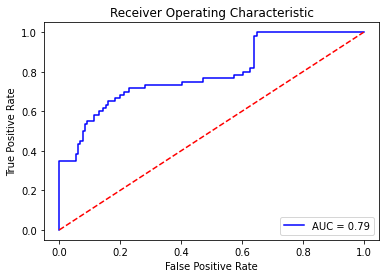

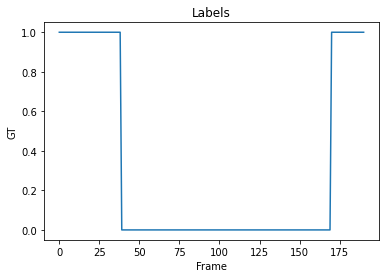

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test021
GT:  21
got model
(200, 256, 256, 1)
got data


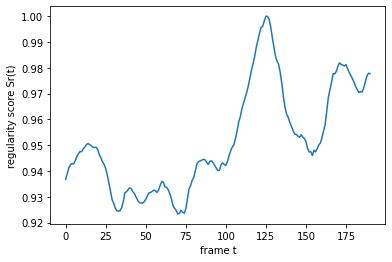

AUC:  0.4604819277108434
EER:  0.5240963855421686
EER THRESHOLD:  0.9474063359170061
Optimal threshold value is: 0.9367863895569004


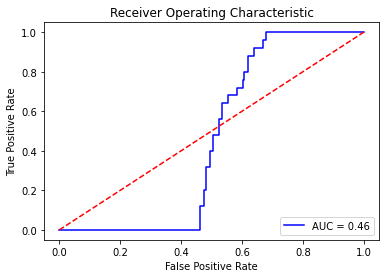

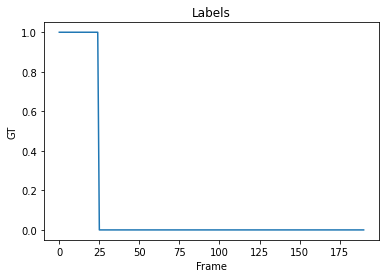

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test022
GT:  22
got model
(200, 256, 256, 1)
got data


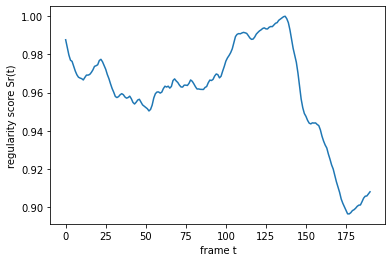

AUC:  0.5421978021978022
EER:  0.4945054945054945
EER THRESHOLD:  0.9633836220055507
Optimal threshold value is: 0.9794002668168682


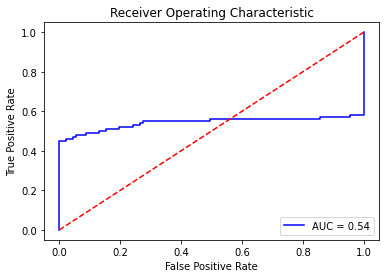

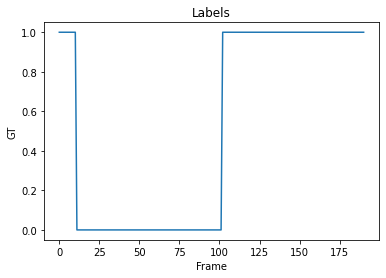

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test023
GT:  23
got model
(200, 256, 256, 1)
got data


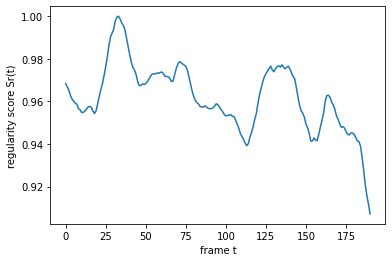

AUC:  0.18340202322967405
EER:  0.7197452229299363
EER THRESHOLD:  0.95641811098606
Optimal threshold value is: 2.0


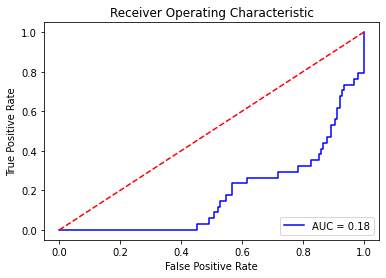

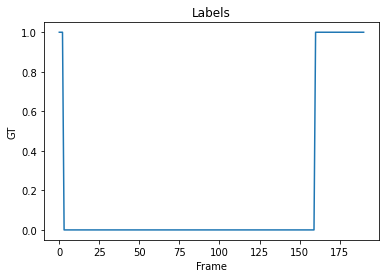

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024
GT:  24
got model
(200, 256, 256, 1)
got data


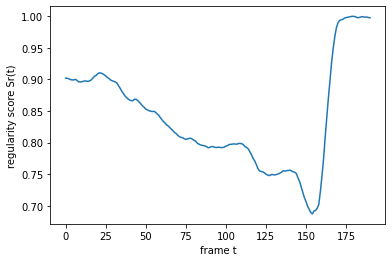

AUC:  0.99607982893799
EER:  0.03278688524590164
EER THRESHOLD:  0.8665785606485337
Optimal threshold value is: 0.8663431493861911


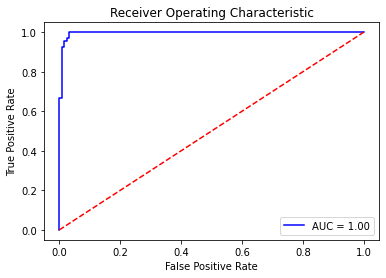

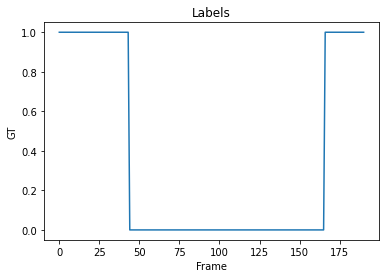

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test025
GT:  25
got model
(200, 256, 256, 1)
got data


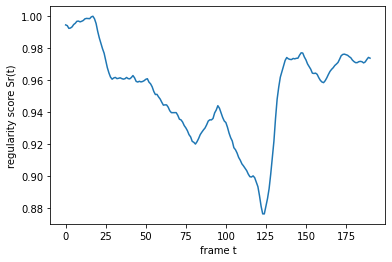

AUC:  0.9717105263157895
EER:  0.11458333333333333
EER THRESHOLD:  0.9606112914534023
Optimal threshold value is: 0.9611283174603245


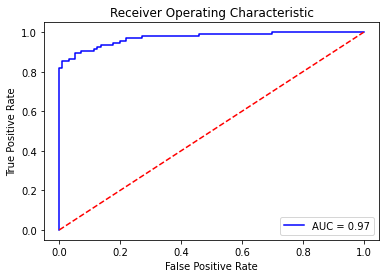

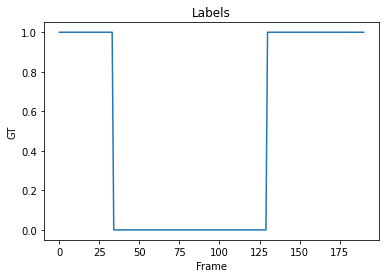

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test026
GT:  26
got model
(200, 256, 256, 1)
got data


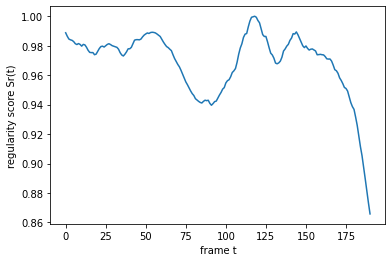

AUC:  0.623736157920077
EER:  0.34328358208955223
EER THRESHOLD:  0.9742546155628322
Optimal threshold value is: 0.9695650372807563


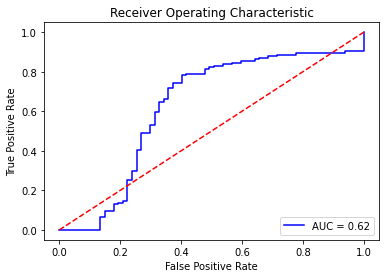

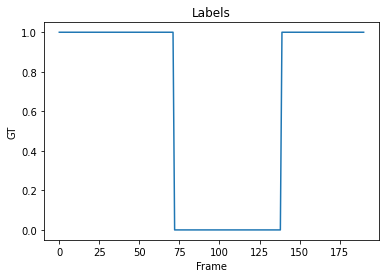

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test027
GT:  27
got model
(200, 256, 256, 1)
got data


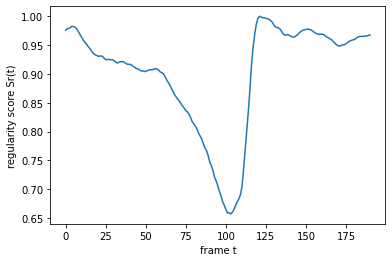

AUC:  0.9554118447923757
EER:  0.08849557522123894
EER THRESHOLD:  0.951856614315277
Optimal threshold value is: 0.9461878545270599


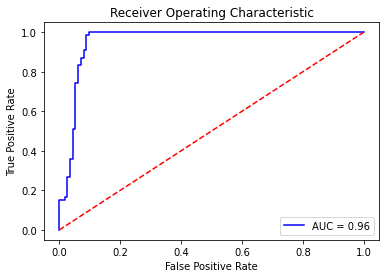

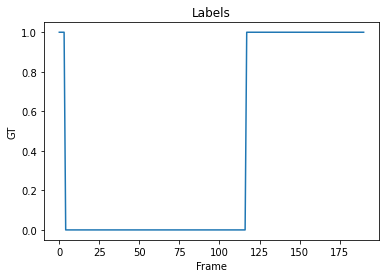

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test028
GT:  28
got model
(200, 256, 256, 1)
got data


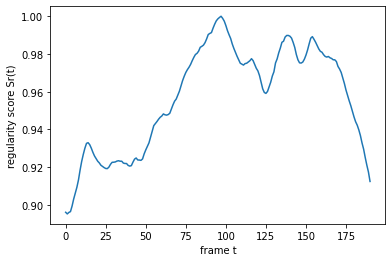

AUC:  0.23320158102766803
EER:  0.7391304347826086
EER THRESHOLD:  0.9658989346026304
Optimal threshold value is: 0.9903086799498751


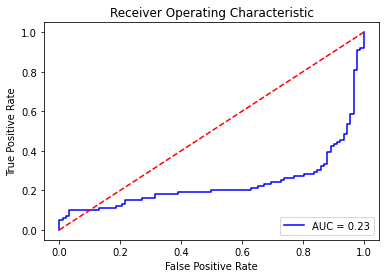

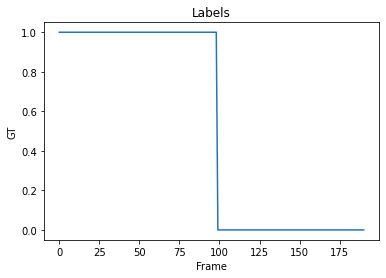

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test029
GT:  29
got model
(200, 256, 256, 1)
got data


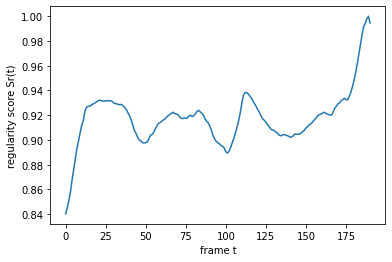

AUC:  0.8167947558770344
EER:  0.31645569620253167
EER THRESHOLD:  0.9173231327227798
Optimal threshold value is: 0.9218707315826185


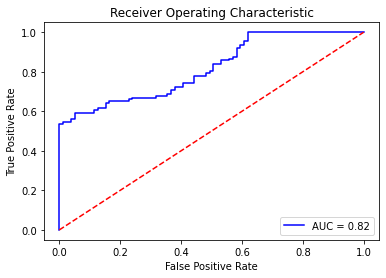

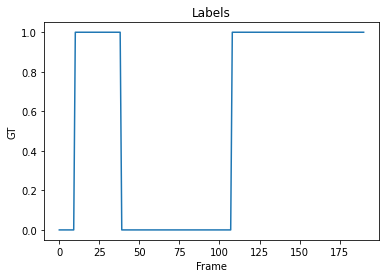

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test030
GT:  30
got model
(200, 256, 256, 1)
got data


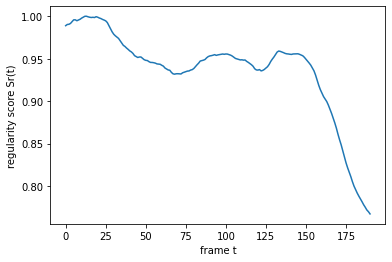

AUC:  1.0
EER:  0.0
EER THRESHOLD:  0.8743005948620066
Optimal threshold value is: 0.8743005948620066


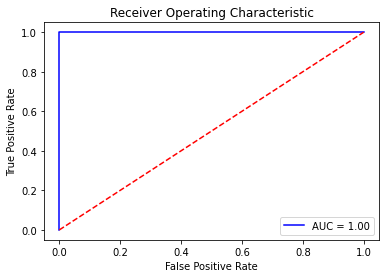

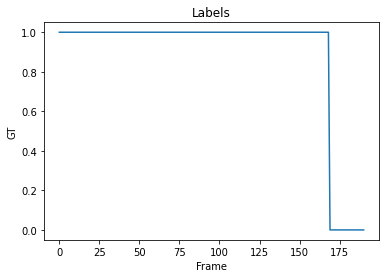

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test031
GT:  31
got model
(200, 256, 256, 1)
got data


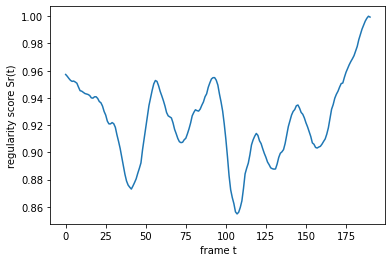

AUC:  1.0
EER:  0.0
EER THRESHOLD:  0.958791202652081
Optimal threshold value is: 0.958791202652081


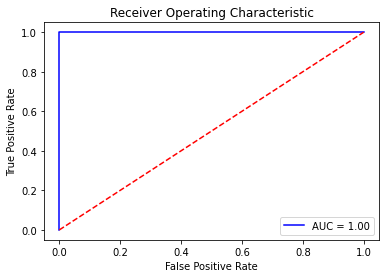

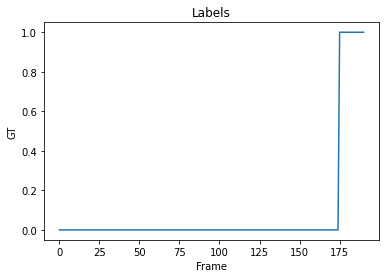

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032
GT:  32
got model
(200, 256, 256, 1)
got data


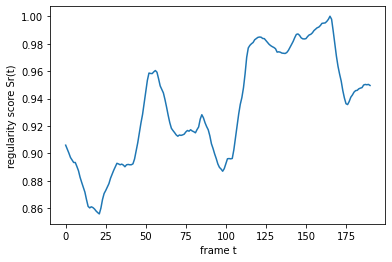

AUC:  0.9930875576036866
EER:  0.04081632653061224
EER THRESHOLD:  0.9362053516566107
Optimal threshold value is: 0.9355763156056359


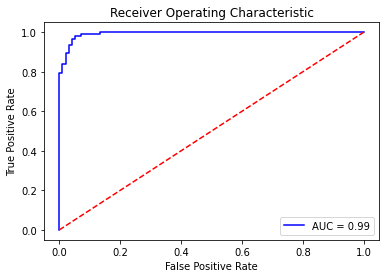

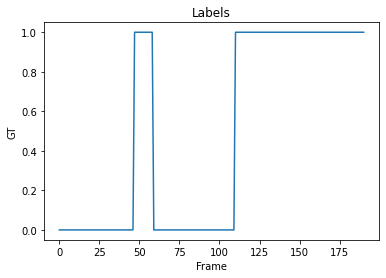

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test033
GT:  33
got model
(200, 256, 256, 1)
got data


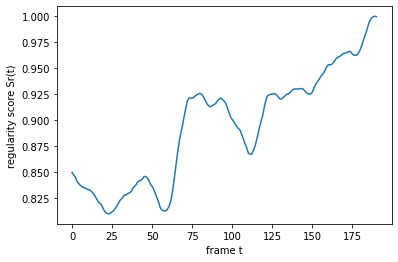

AUC:  1.0
EER:  0.0
EER THRESHOLD:  0.953262478596119
Optimal threshold value is: 0.953262478596119


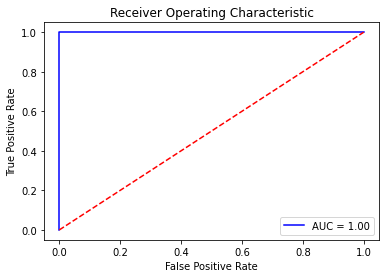

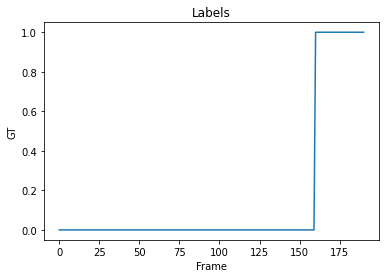

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test034
GT:  34
got model
(200, 256, 256, 1)
got data


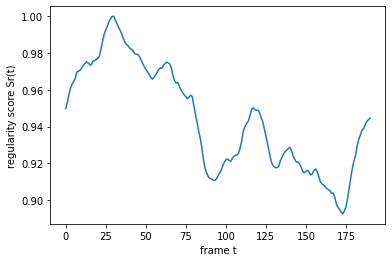

AUC:  0.12873563218390804
EER:  0.7758620689655172
EER THRESHOLD:  0.9339251524693013
Optimal threshold value is: 2.0


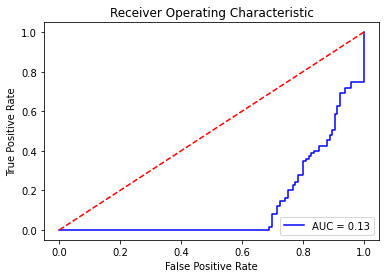

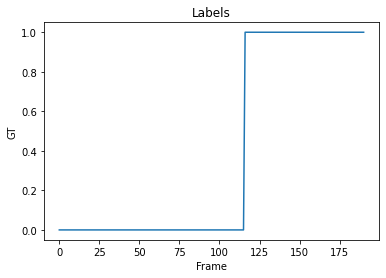

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test035
GT:  35
got model
(200, 256, 256, 1)
got data


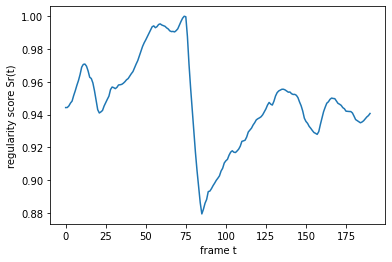

AUC:  0.9474099099099099
EER:  0.16216216216216217
EER THRESHOLD:  0.9492950206940433
Optimal threshold value is: 0.9544398214241494


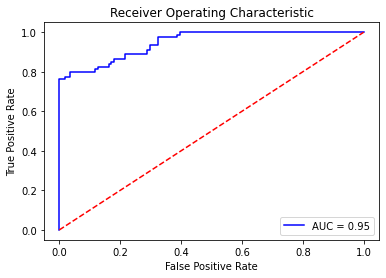

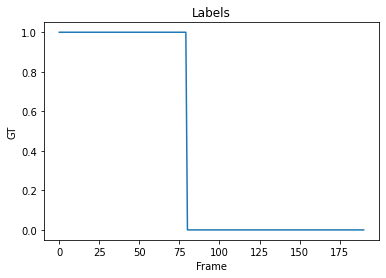

PATH:  UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test036
GT:  36
got model
(200, 256, 256, 1)
got data


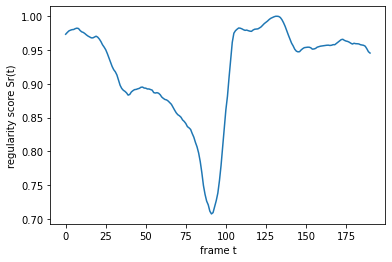

AUC:  0.9106163632375521
EER:  0.1702127659574468
EER THRESHOLD:  0.9543516965678648
Optimal threshold value is: 0.9454960122376237


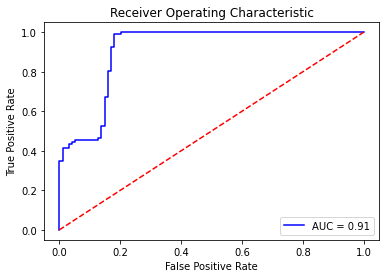

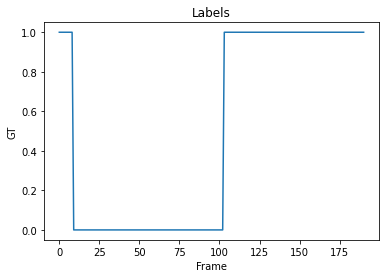

AUC:  0.7797525746632576
EER:  0.23093412427133297


In [13]:
from os import listdir
from os.path import isfile, join, isdir


clips = []
# loop over the training folders (Train000,Train001,..)
for f in sorted(listdir(Config.TEST_PATH)):
    if isdir(join(Config.TEST_PATH, f)):
      if not 'gt' in f:
        clips.append(join(Config.TEST_PATH, f))


scores = []

for i in range(len(clips)):
  if(i == 16): #skip clip 17
    continue

  Config.SINGLE_TEST_PATH = clips[i]
  Config.SINGLE_TEST_VIDEO_FILE = i+1

  print("PATH: ", Config.SINGLE_TEST_PATH)
  print("GT: ", Config.SINGLE_TEST_VIDEO_FILE)

  pr, before_reconstuction = evaluate()
  scores.append(plotROC(pr))


mean = np.mean(scores, axis=0)
#print(scores)
print("AUC: ", mean[0])
print("EER: ", mean[1])